In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 2
setup_one_gpu(GPU)

Picking GPU 2


In [2]:
import sys
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt
from functools import partial

from general_tools.notebook.tf import reset_tf_graph
from general_tools.in_out import create_dir
from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs

from geo_tool import Point_Cloud

from tf_lab.in_out.basics import Data_Splitter
from tf_lab.point_clouds.ae_templates import mlp_architecture_ala_iclr_18, default_train_params

from tf_lab.point_clouds.autoencoder import Configuration as Conf
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder

from tf_lab.point_clouds.in_out import load_point_clouds_from_filenames, PointCloudDataSet
from tf_lab.data_sets.shape_net import pc_loader as snc_loader
from tf_lab.data_sets.shape_net import snc_category_to_synth_id

from tf_lab.iclr.helper import load_multiple_version_of_pcs, find_best_validation_epoch_from_train_stats

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
top_data_dir = '/orions4-zfs/projects/optas/DATA/'
experiment_tag = 'mlp_with_split_1pc_usampled_bnorm_on_encoder_only_antipoints'
loss = 'chamfer'
n_pc_points = 2048
random_seed = 42
bneck = 128
class_name = raw_input('Give me the class type: ').lower()

In [5]:
syn_id = snc_category_to_synth_id()[class_name]
in_data = load_multiple_version_of_pcs('uniform_one' ,syn_id, n_classes=1)

679 pclouds were loaded. They belong in 1 shape-classes.
5761 pclouds were loaded. They belong in 1 shape-classes.
338 pclouds were loaded. They belong in 1 shape-classes.


In [8]:
train_params = default_train_params()

experiment_id = '_'.join(['ae', class_name, experiment_tag, str(n_pc_points), 'pts', str(bneck), 'bneck', loss])
train_dir = osp.join(top_data_dir, 'OUT/iclr/nn_models/post_deadline', experiment_id)
create_dir(train_dir)

reset_tf_graph()
encoder, decoder, enc_args, dec_args = mlp_architecture_ala_iclr_18(n_pc_points, bneck)    
conf = Conf(n_input = [n_pc_points, 3],
            loss = loss,
            training_epochs = 500,
            batch_size = train_params['batch_size'],
            denoising = False,
            learning_rate = train_params['learning_rate'],
            train_dir = train_dir,
            loss_display_step = 1,
            saver_step = train_params['saver_step'],
            z_rotate = False,
            encoder = encoder,
            decoder = decoder,
            encoder_args = enc_args,
            decoder_args = dec_args                
           )

print conf

conf.experiment_name = 'experiment_' + str(experiment_id)
conf.held_out_step = 5
conf.save(osp.join(train_dir, 'configuration'))

                    batch_size: 50
                 consistent_io: None
                         debug: False
                       decoder: decoder_with_fc_only
                  decoder_args: {'b_norm_finish': False, 'verbose': True, 'b_norm': False, 'layer_sizes': [256, 256, 6144]}
                       encoder: encoder_with_convs_and_symmetry_new
                  encoder_args: {'filter_sizes': [1], 'n_filters': [64, 128, 128, 256, 128], 'verbose': True, 'b_norm': True, 'strides': [1]}
                 gauss_augment: None
                  is_denoising: False
               latent_vs_recon: 1.0
                 learning_rate: 0.0005
                          loss: chamfer
             loss_display_step: 1
                       n_input: [2048, 3]
                      n_output: [2048, 3]
                           n_z: None
             saver_max_to_keep: None
                    saver_step: 10
                     train_dir: /orions4-zfs/projects/optas/DATA/OUT/iclr/nn_models/po

In [13]:
from tf_lab.external.structural_pc_losses import losses
nn_distance, approx_match, match_cost = losses()

def _create_loss(self):        
    self.anti_pc = tf.placeholder(tf.float32, [None] + self.n_input)    
    c = self.configuration
    mean = tf.reduce_mean
    if c.loss == 'chamfer':
        cost_p1_p2, _, cost_p2_p1, _ = nn_distance(self.x_reconstr, self.gt)
        anti_cost_p1_p2, _, anti_cost_p2_p1, _ = nn_distance(self.x_reconstr, self.anti_pc)        
        
        p1p2 = tf.relu(cost_p1_p2 - anti_cost_p1_p2)
        p2p1 = tf.relu(cost_p2_p1 - anti_cost_p2_p1)        
        self.loss = mean(cost_p1_p2) + mean(cost_p2_p1) + mean(p1p2) + mean(p2p1)


def _single_epoch_train(self, train_data, configuration, only_fw=False):
    n_examples = train_data.num_examples
    epoch_loss = 0.
    batch_size = configuration.batch_size
    n_batches = int(n_examples / batch_size)
    start_time = time.time()

    if only_fw:
        fit = self.reconstruct
    else:
        fit = self.partial_fit

    # Loop over all batches
    for _ in xrange(n_batches):
        gt_pc, _, anti_pc = train_data.next_batch(batch_size)
        
        
        is_training(True, session=self.sess)
        try:
            _, loss, recon = self.sess.run((self.train_step, self.loss, self.x_reconstr), feed_dict={self.x: X, self.gt: GT})

            is_training(False, session=self.sess)
        except Exception:
            raise
        finally:
            is_training(False, session=self.sess)
        return recon, loss

        batch_i = apply_augmentations(batch_i, configuration)   # This is a new copy of the batch.

        if self.is_denoising:
            _, loss = fit(batch_i, original_data)
        else:
            _, loss = fit(batch_i)

        # Compute average loss
        epoch_loss += loss
    epoch_loss /= n_batches
    duration = time.time() - start_time
    return epoch_loss, duration        

PointNetAutoEncoder._create_loss = _new_create_loss
reset_tf_graph()
ae = PointNetAutoEncoder(conf.experiment_name, conf)




Building Encoder
encoder_conv_layer_0 conv params =  256 bnorm params =  128
Tensor("experiment_ae_chair_mlp_with_split_1pc_usampled_bnorm_on_encoder_only_antipoints_2048_pts_128_bneck_chamfer_2/Relu:0", shape=(?, 2048, 64), dtype=float32)
output size: 131072 

encoder_conv_layer_1 conv params =  8320 bnorm params =  256
Tensor("experiment_ae_chair_mlp_with_split_1pc_usampled_bnorm_on_encoder_only_antipoints_2048_pts_128_bneck_chamfer_2/Relu_1:0", shape=(?, 2048, 128), dtype=float32)
output size: 262144 

encoder_conv_layer_2 conv params =  16512 bnorm params =  256
Tensor("experiment_ae_chair_mlp_with_split_1pc_usampled_bnorm_on_encoder_only_antipoints_2048_pts_128_bneck_chamfer_2/Relu_2:0", shape=(?, 2048, 128), dtype=float32)
output size: 262144 

encoder_conv_layer_3 conv params =  33024 bnorm params =  512
Tensor("experiment_ae_chair_mlp_with_split_1pc_usampled_bnorm_on_encoder_only_antipoints_2048_pts_128_bneck_chamfer_2/Relu_3:0", shape=(?, 2048, 256), dtype=float32)
output size

In [19]:
buf_size = 1 # flush each line
fout = open(osp.join(conf.train_dir, 'train_stats.txt'), 'a', buf_size)
#     train_stats = ae.train(in_data['train'], conf, log_file=fout, held_out_data=in_data['val'])
train_stats = ae.train(in_data['train'], conf, log_file=fout, held_out_data=in_data['test'])
fout.close()

('Epoch:', '0001', 'training time (minutes)=', '0.1089', 'loss=', '15.254832085')
INFO:tensorflow:/orions4-zfs/projects/optas/DATA/OUT/iclr/nn_models/ae_chair_mlp_with_split_1pc_usampled_bnorm_on_encoder_only_reduce_log_sum_exp_2048_pts_128_bneck_chamfer/models.ckpt-1 is not in all_model_checkpoint_paths. Manually adding it.
('Epoch:', '0002', 'training time (minutes)=', '0.1067', 'loss=', '15.252292807')
('Epoch:', '0003', 'training time (minutes)=', '0.1069', 'loss=', '15.252097204')
('Epoch:', '0004', 'training time (minutes)=', '0.1073', 'loss=', '15.251831444')
('Epoch:', '0005', 'training time (minutes)=', '0.1101', 'loss=', '15.251728597')
('Held Out Data :', 'forward time (minutes)=', '0.0030', 'loss=', '15.251585740')
('Epoch:', '0006', 'training time (minutes)=', '0.1070', 'loss=', '15.251509161')
('Epoch:', '0007', 'training time (minutes)=', '0.1066', 'loss=', '15.251545889')
('Epoch:', '0008', 'training time (minutes)=', '0.1073', 'loss=', '15.251379146')
('Epoch:', '0009'

KeyboardInterrupt: 

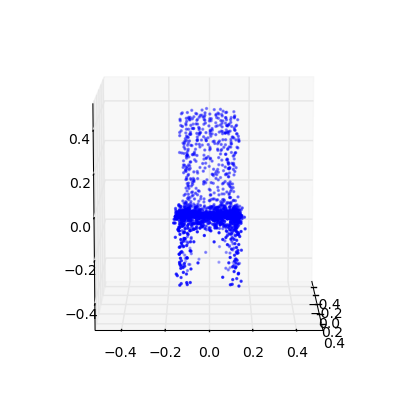

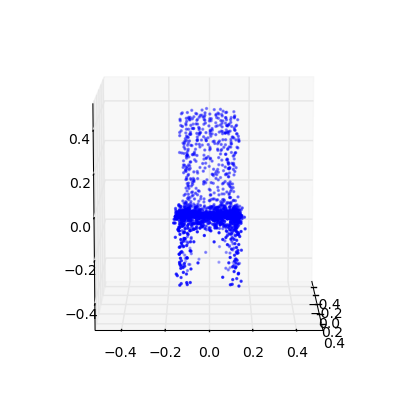

In [29]:
from tf_lab.point_clouds.convenience import reconstruct_pclouds
bb = reconstruct_pclouds(ae, in_data['test'].point_clouds[10:11], 1)
Point_Cloud(bb[0][0]).plot(azim=0)
# ae.reconstruct(in_data['test'])